In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import re
import os
import csv

from sklearn.datasets import load_boston
from sklearn.utils import shuffle,resample

%matplotlib inline

In [65]:
class Node():
    
    def __init__(self, inputs = []):
        self.inputs = inputs
        self.outputs = []
        
        for n in self.inputs:
            n.outputs.append(self)
        
        self.value = None
        self.gradients = {}
    
    def forward(self):
        raise NotImplemented
        
    def backward(self):
        raise NotImplemented
        
    def __repr__(self):
        return ('{}'.format(self.__class__.__name__))
    
    

class Input(Node):
    def __init__(self, name='Input'):
        self.name = name
        Node.__init__(self)
        
    def forward(self, value=None):
        if value is not None:
            self.value = value
    
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost*1
            
    def __repr__(self):
        return ('{}({!r})'.format(self.__class__.__name__, self.name))
    
    

class Linear(Node):
    def __init__(self, nodes, weights, biases, name='Linear'):
        self.name=name
        Node.__init__(self, inputs=[nodes, weights, biases])
        
    def forward(self):
        x = self.inputs[0].value
        w = self.inputs[1].value
        b = self.inputs[2].value
        self.value = np.dot(x, w)+b
    
    def backward(self):
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)
    
    def __repr__(self):
        return ('{}({!r})'.format(self.__class__.__name__, self.name))
    
            

class Sigmoid(Node):
    def __init__(self, nodes, name='Sigmoid'):
        self.name=name
        Node.__init__(self, inputs=[nodes])
        
    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))
    
    def forward(self):
        self.value = self._sigmoid(self.inputs[0].value)
        
    def backward(self):
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            y = self._sigmoid(self.inputs[0].value)
            self.gradients[self.inputs[0]] = grad_cost * (y*(1-y))
                   
    def __repr__(self):
        return ('{}'.format(self.__class__.__name__))
    
    

class MSE(Node):
    def __init__(self, y, y_hat, name='MSE'):
        self.name=name
        Node.__init__(self, inputs=[y, y_hat])
        
    def forward(self):
        self.value = np.mean((self.inputs[0].value.reshape(-1,1)-self.inputs[1].value.reshape(-1,1))**2)
        
    def backward(self):
        m = self.inputs[0].value.shape[0]    
        self.gradients[self.inputs[0]] = (2/m)*(self.inputs[0].value.reshape(-1,1)-self.inputs[1].value.reshape(-1,1))
        self.gradients[self.inputs[1]] = (-2/m)*(self.inputs[0].value.reshape(-1,1)-self.inputs[1].value.reshape(-1,1)) 
            
    def __repr__(self):
        return ('{}'.format(self.__class__.__name__))
    
    
    
def top_logic_sort(feeds:dict):
    feed_node = [key for key in feeds.keys()]
    g = {}
    
    nodes = [node for node in feed_node]
    while nodes:
        node = nodes.pop(0)
        if not node in  g:
            g[node] = {'in': set(), 'out': set()}
            for n in node.inputs:
                g[node]['in'].add(n)
            for n in node.outputs:
                g[node]['out'].add(n)
                nodes.append(n)
                
    nodes = [node for node in g.keys()]
    s = []
    while nodes:
        node = nodes.pop(0)
        
        if isinstance(node, Input):
            node.value = feeds[node]

        if g[node]['in'] == set():
            s.append(node)
            for n in node.outputs:
                g[n]['in'].remove(node)
                g[node]['out'].remove(n)
        else:
            nodes.append(node)           
    return s




def forward_and_backward(graph):
    for node in graph:
        node.forward()
        
    for node in graph[::-1]:
        node.backward()
        
        

def sgd_update(trainables, lr=1e-2):    
    for t in trainables:
        t.value += -1 * lr * t.gradients[t]

In [66]:
boston = load_boston()
data = boston['data']
data_norm = (data-np.mean(data, axis=0))/np.std(data, axis=0)
target = boston['target']

batch_size = 32
batch_num = data.shape[0]//batch_size
feature_num = data.shape[1]
hidder_size = 10
lr = 0.01
epochs = 1000


epoch: 0, loss: 272.32
epoch: 100, loss: 9.19
epoch: 200, loss: 8.34
epoch: 300, loss: 6.58
epoch: 400, loss: 5.06
epoch: 500, loss: 6.48
epoch: 600, loss: 6.63
epoch: 700, loss: 5.57
epoch: 800, loss: 5.75
epoch: 900, loss: 5.30


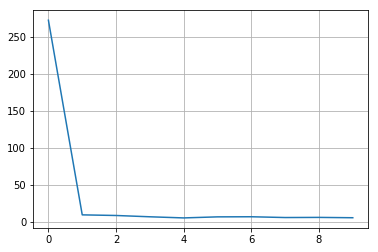

In [67]:
x = Input('Input_x')
y = Input('Input_y')
w1 = Input('Input_w1')
b1 = Input('Input_b1')
w2 = Input('Input_w2')
b2 = Input('Input_b2')
linear1 = Linear(x, w1, b1, name='Linear_1')
sigmoid = Sigmoid(linear1)
linear2 = Linear(sigmoid, w2, b2, name='Linear_2')
cost = MSE(linear2, y)

x_= data_norm
y_ = target.reshape(-1, 1)
w1_ = np.random.randn(feature_num, hidder_size)
b1_ = np.zeros(hidder_size)
w2_ = np.random.randn(hidder_size, 1)
b2_ = np.zeros(1)

feed_input = {
    x: x_,
    y: y_,
    w1: w1_,
    b1: b1_,
    w2: w2_,
    b2: b2_,
}
train_vars = [w1, b1, w2, b2]

graph = top_logic_sort(feed_input)
losses = []

for i in range(epochs):
    loss = 0
    for j in range(batch_num):
        
        x_batch, y_batch = resample(x_, y_, n_samples=batch_size)
        x.value = x_batch
        y.value = y_batch
        
        forward_and_backward(graph)
        sgd_update(train_vars,lr)
        
        loss += cost.value
        
    loss = loss/batch_num    
    if i%100 == 0:
        print('epoch: {}, loss: {:.2f}'.format(i, loss))
        losses.append(loss)

plt.plot(losses)
plt.grid(True)
plt.show()